### **Data Generator: Train**

#### **Import libraries and Define augmentations**

In [40]:
# Import the necessary libraries
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import random
import shutil
from ultralytics import YOLO
from tqdm import tqdm

# Augmentations
import albumentations as A
from albumentations.augmentations.geometric.resize import RandomScale, LongestMaxSize
from albumentations.augmentations.geometric.transforms import OpticalDistortion
from albumentations.augmentations.domain_adaptation import FDA

Define constants

In [3]:
# Spatial-preserving augmentations
BOX_TRANSFORMS = A.Compose([
    # Resizing augmentations
    A.OneOf([
        RandomScale(scale_limit=[-0.3, 0.3]),
        LongestMaxSize(max_size=range(20, 40))
    ]),
    # Geometric augmentations
    A.OneOf([
        #Affine(scale=(0.1, 0.2), rotate=(-90, 90), shear=(-45, 45), cval=range(128, 255), keep_ratio=True),
        OpticalDistortion(distort_limit = [0.5,0.55], shift_limit = 0, interpolation = 1, border_mode = cv2.BORDER_REPLICATE)
    ], p=0.5),
    # Orientation augmentations
    A.OneOf([
        A.RandomRotate90(),
        A.Flip()
    ]),
    # Brightness/contrast augmentations
    A.OneOf([
        A.RandomGamma(gamma_limit=(50, 150)),
        A.CLAHE(),
        A.ColorJitter(),
        A.Sharpen()
    ]),
    # Color
    A.OneOf([
        A.HueSaturationValue(),
        A.ToGray(),
        A.FancyPCA(),
        A.ChannelShuffle()
    ])
], p=0.5)

In [4]:
BLOCK_TRANSFORMS = A.Compose([
    # Resizing augmentations
    A.OneOf([
        RandomScale(scale_limit=[-0.3, 0.3])
    ]),
    # Brightness/contrast augmentations
    A.OneOf([
        A.RandomGamma(gamma_limit=(50, 150)),
        A.CLAHE(),
        A.ColorJitter(),
        A.Sharpen()
    ]),
    # Color
    A.OneOf([
        A.HueSaturationValue(),
        A.ToGray(),
        A.FancyPCA(),
        A.ChannelShuffle()
    ])
], p=0.5)

In [5]:
DOCUMENT_TRANSFORM = A.Compose([
    A.OneOf([
        A.RGBShift(),
        A.ToSepia(),
        A.RandomToneCurve(),
        A.ToGray()
    ]
    )
], p=0.5)

In [6]:
CLASSES = {
    "unchecked": 0,
    "checked": 1,
    "block": 2
}

#### **Define helper functions**

In [25]:
# Create folders
def create_folder(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [7]:
def save_image(new_path, image):
    """
    Save a new image with given path
    
    """
    cv2.imwrite(new_path, image)

In [8]:
def visualize(image, dim=10):
    """
    Visualizing document images with given dimensions

    """
    plt.figure(figsize=(dim, dim))
    plt.axis('off')
    plt.imshow(image)

In [16]:
def preprocess_augmentations(list_image_paths, destination_folder, transforms):
    """
    Apply a set of augmentations to a list of images and save newly augmented images

    Args:
    - list_image_paths: list of paths to images to apply augmentations onto
    - transforms: set of albumentations transforms to augment images

    """
    for image_path in list_image_paths:
        image = cv2.imread(image_path) # Read the image
        if image is None: # skip if link to image is invalid/format type is not supported
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        transformed = transforms(image=image)['image']
        # Save the transformed images
        cv2.imwrite(os.path.join(destination_folder, f"{os.path.splitext(os.path.basename(image_path))[0] + '_transformed.jpg'}"), transformed)

In [24]:
def isVerticalBlock(image):
    """
    Check if a given block group is vertical

    Args:
    - image: cv2 image to check dimensions

    Return: true if an image is vertical, false otherwise
    """
    h, w = image.shape[:-1]
    if (w < h): return True
    return False

Get paths to checkboxes and group box:

In [9]:
unticked = "datasets/boxes/unchecked/"
ticked = "datasets/boxes/checked/"
group = "datasets/boxes/block/"
nonbox = "datasets/boxes/non-boxes/"

# Get paths to each category's boxes images
_, _, unticked_image_paths = next(os.walk(unticked)) 
complete_unticked_image_paths = [os.path.join(unticked, x) for x in unticked_image_paths if x != '.DS_Store']
_, _, ticked_image_paths = next(os.walk(ticked)) 
complete_ticked_image_paths = [os.path.join(ticked, x) for x in ticked_image_paths if x != '.DS_Store']
_, _, block_image_paths = next(os.walk(group))
complete_block_image_paths = [os.path.join(group, x) for x in block_image_paths if x != '.DS_Store']

# Get paths to non-boxes images
_, _, nonbox_image_paths = next(os.walk(nonbox))
complete_nonbox_image_paths = [os.path.join(nonbox, x) for x in nonbox_image_paths if x != '.DS_Store']
complete_nonbox_image_paths = np.array(complete_nonbox_image_paths)
random.shuffle(complete_nonbox_image_paths)

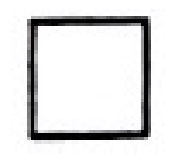

In [12]:
# Visualize 1 sample for each type
unticked_sample = cv2.imread(complete_unticked_image_paths[0])
visualize(unticked_sample, 2)

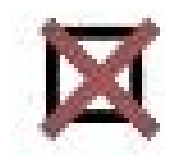

In [13]:
ticked_sample = cv2.imread(complete_ticked_image_paths[0])
visualize(ticked_sample, 2)

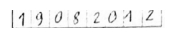

In [14]:
block_sample = cv2.imread(complete_block_image_paths[0])
visualize(block_sample, 2)

Because of data limitations, we might want to augment block images first

In [15]:
PREPROCESS_TRANSFORMS = A.Compose([
    # Resizing augmentations
    A.OneOf([
        RandomScale(scale_limit=[-0.3, 0.3]),
        LongestMaxSize(max_size=range(300, 600))
    ]),
    # Brightness/contrast augmentations
    A.OneOf([
        #A.RandomGamma(gamma_limit=(50, 150)),
        #A.CLAHE(),
        #A.ColorJitter(),
        A.Sharpen()
    ]),
    # Color
    A.OneOf([
        A.HueSaturationValue(),
        A.ToGray(),
        A.FancyPCA(),
        A.ChannelShuffle()
    ])
], p=1)

In [ ]:
# preprocess_augmentations(complete_block_image_paths, group, PREPROCESS_TRANSFORMS) # Run once

For the same reason, we might also want to augment more documents to paste checkboxes onto

In [17]:
document = "datasets/train_val/rvl_boxes/train/images"
document_image_paths = next(os.walk(document))[2]
# Get all unedited images
complete_document_image_paths = [os.path.join(document, x) for x in document_image_paths if x.find(".DS_Store") < 0]

In [19]:
DOCUMENT_AUGMENT_TRANSFORMS = A.Compose([
    # Brightness/contrast augmentations
    A.OneOf([
        A.RandomGamma(gamma_limit=(50, 150)),
        A.CLAHE(),
        A.ColorJitter(),
        A.Sharpen()
    ]),
    # Color transformations
    A.OneOf([
        A.RGBShift(),
        A.ToSepia(),
        A.RandomToneCurve()
    ]
    )
], p=0.7)

In [ ]:
# preprocess_augmentations(complete_document_image_paths, document, DOCUMENT_AUGMENT_TRANSFORMS) # Run once

For the specific task in hand, we will only pay attention to grouped boxes that are horizontally ordered, which means boxes that look as follows will be ruled out

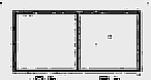

In [20]:
_, _, block_image_paths = next(os.walk(group))
complete_block_image_paths = [os.path.join(group, x) for x in block_image_paths if x != '.DS_Store']

In [15]:
# Rule out vertical boxes
for path in complete_block_image_paths:
    image = cv2.imread(path)
    if image is None:
        continue
    if isVerticalBlock(image): # Check to see if the current image is a vertical block
        os.remove(path)

After augmentations, check to see the number of items in each category:

In [21]:
# Reload the paths after transformation
_, _, unticked_image_paths = next(os.walk(unticked)) 
complete_unticked_image_paths = [os.path.join(unticked, x) for x in unticked_image_paths if x != '.DS_Store']
_, _, ticked_image_paths = next(os.walk(ticked)) 
complete_ticked_image_paths = [os.path.join(ticked, x) for x in ticked_image_paths if x != '.DS_Store']
_, _, block_image_paths = next(os.walk(group))
complete_block_image_paths = [os.path.join(group, x) for x in block_image_paths if x != '.DS_Store']

# Get the circle boxes also
complete_unchecked_circle_image_paths = [x for x in complete_unticked_image_paths if x.find('circle') > 0]
complete_checked_circle_image_paths = [x for x in complete_ticked_image_paths if x.find('circle') > 0]

In [22]:
print(f"Number of unticked checkboxes: {len(complete_unticked_image_paths)}, number of ticked checkboxes: {len(complete_ticked_image_paths)}, number of block checkboxes: {len(complete_block_image_paths)}")

Number of unticked checkboxes: 13052, number of ticked checkboxes: 5923, number of block checkboxes: 5502


In [23]:
def generate_list_checkbox(num_unchecked=20, num_checked=20, num_block=4, num_noncheckboxes = 10):
    """
    Generate a list of random checkboxes from dataset with applied augmentations

    Args:
    - num_unchecked: number of unchecked box desired
    - num_checked: number of checked box desired
    - num_block: number of block box desired
    - num_noncheckboxes: number of distractors desired

    Return: 
    - array of all transformed boxes and non checkboxes
    - array of indices of checkbox existing in the list
    - corresponding array of class of each checkbox

    """
    # Ensure that circle checkboxes are also selected
    unchecked_circle_num = random.randint(2, 5)
    checked_circle_num = random.randint(2, 5)
    uncheckeds = random.choices(complete_unchecked_circle_image_paths, k=unchecked_circle_num)
    checkeds = random.choices(complete_checked_circle_image_paths, k=checked_circle_num)
    
    # Get the full list of unchecked, checked and block checkboxes
    uncheckeds.extend(random.choices(complete_unticked_image_paths, k=num_unchecked-unchecked_circle_num))
    checkeds.extend(random.choices(complete_ticked_image_paths, k=num_checked-checked_circle_num))
    blocks = random.choices(complete_block_image_paths, k=num_block)
    checkbox_group = []
    checkbox_group.extend(uncheckeds)
    checkbox_group.extend(checkeds)
    checkbox_group.extend(blocks)

    # Add distractors to the checkbox groups to avoid cheating
    checkbox_group.extend(random.choices(complete_nonbox_image_paths, k=num_noncheckboxes))

    # Shuffle the array
    checkbox_group = np.array(checkbox_group)
    random.shuffle(checkbox_group)
    list_allboxes = []
    checkboxes_indices = []
    checkboxes_classes = []
    
    count = 0 # Keep track of boxes indices
    for path in checkbox_group:
        # Read image
        image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        # If file is non-existent/link is incorrect
        if image is None:
            #print(path)
            continue
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w = image.shape[:-1]
        
        # Check the type of checkbox it is: 0) unchecked, 1) checked, 2) block
        checkbox_type = os.path.basename(os.path.dirname(path))
        
        # If it is of individual checkbox type
        if checkbox_type == "unchecked" or checkbox_type == "checked" or checkbox_type == "non-boxes":
            image = BOX_TRANSFORMS(image=image)['image']
            # Resize too small images
            if (h < 12 or w < 12):
                image = cv2.resize(image, (12, 12), interpolation=cv2.INTER_LINEAR)
            # Resize individual checkboxes that are too big
            elif (h > 50 or w > 50):
                image = cv2.resize(image, (int(w/2), int(h/2)), interpolation=cv2.INTER_LINEAR)
            
        else: # Otherwise, if it is of group checkbox type
            image = BLOCK_TRANSFORMS(image=image)['image']
            if isVerticalBlock(image):
                image = A.Rotate(p=1)(image=image)['image'] # Rotate the image
            if w > 600:
                ratio = float(h)/w
                new_w = 600
                image = cv2.resize(image, (new_w, int(new_w * ratio)), interpolation=cv2.INTER_LINEAR)

        # If the given box is a checkbox, save its index in the checkboxes_indices array
        if checkbox_type != "non-boxes":
            checkboxes_indices.append(count)
            checkboxes_classes.append(CLASSES[checkbox_type])
            #print(f"Box num: {count}, class: {CLASSES[checkbox_type]}")
        
        # Add the checkboxes to list of all checkboxes
        list_allboxes.append(image)
        count += 1

    return list_allboxes, checkboxes_indices, checkboxes_classes

In [26]:
# Test the above-defined function
test_boxes = generate_list_checkbox(num_unchecked=10, num_checked=10, num_block=1, num_noncheckboxes=3)
print(f"Checkbox indices: {test_boxes[1]}, checkbox classes: {test_boxes[2]}")

Checkbox indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 19, 21, 22, 23], checkbox classes: [1, 0, 0, 1, 0, 2, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1]


#### **Copy Paste checkboxes on Documents**

Define helper functions:

In [27]:
# Define a point class with given x, y
class Point():
    """
    Represent a point with x,y coordinates
    
    Attributes:
    - X: x-value
    - y: y-value

    Methods:
    - get_X(): return x value
    - get_Y(): return y value
    - toString: print x,y values
    """
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def get_X(self):
        return self.X
    def get_Y(self):
        return self.y
    def toString(self):
        return f"({self.X}, {self.y})"

In [28]:
MIN_BOX_DISTANCE = 10 # Allow some noticeable margins between boxes
def isOverlap(rect1_tl, rect1_br, rect2_tl, rect2_br):
    """
    Check if 2 rectangles are overlapping

    Args:
    - rect1_tl: rectangle 1's top left point
    - rect1_br: rectangle 1's bottom right point
    - rect2_tl: rectangle 2's top left point
    - rect2_br: rectangle 2's bottom right point

    Return: true if 2 rectangles overlap, false otherwise
    """
    # If one rectangle is above another 
    if (rect1_tl.get_Y() > rect2_br.get_Y() + MIN_BOX_DISTANCE or rect1_br.get_Y() + MIN_BOX_DISTANCE < rect2_tl.get_Y()):
        return False
    # If one rectangle is completely to the left of another
    if (rect1_br.get_X() + MIN_BOX_DISTANCE < rect2_tl.get_X() or rect1_tl.get_X() > rect2_br.get_X() + MIN_BOX_DISTANCE):
        return False 
    return True

def isBoxOverlappingSetOfBoxes(tl, br, setBoxes):
    """
    Check if a box overlaps any boxes in a set of boxes given top left and bottom right points of that box

    Args:
    - tl: the rectangle's top left point
    - br: the rectangle's bottom right point
    - setBoxes: an array of boxes' coordinates 

    Return: true if 2 rectangles overlap, false otherwise
    """
    if len(setBoxes) == 0: 
        return False
    for box in setBoxes:
        text_topleft = Point(box[0], box[1])
        text_bottomright = Point(box[2], box[3])
        if isOverlap(tl, br, text_topleft, text_bottomright):
            return True 
    return False
    
def outputCopyPasteValues(box_width, box_height, image_width, image_height):
    """
    Output x_offset, y_offset (top left), x_end, y_end (bottom right) points 
    given width of image and width of box

    Args:
    - box_width: width of checkbox
    - box_height: height of checkbox
    - image_width: width of image to paste checkbox onto
    - image_height: height of image to paste checkbox onto

    Return: a random point on the image
    
    """
    
    x_offset = np.random.choice(range(0, image_width - box_width), size=1)[0]
    y_offset = np.random.choice(range(0, image_height - box_height), size=1)[0]
    x_end = x_offset + box_width
    y_end = y_offset + box_height 
    return x_offset, y_offset, x_end, y_end

In [29]:
def resizeContiguousBoxes(boxes, boxes_indices, checkbox_indices, checkbox_classes):
    """
    Transform square-shaped boxes to have similar dimensions 

    Args:
    - boxes: list of cv2 boxes images in different sizes
    - boxes_indices: list of indices of those given boxes within the original array
    - checkbox_indices: list of indices of all boxes identified as checkbox in the original array
    - checkbox_classes: corresponding list of each checkbox's class

    Return: list of transformed boxes, list of untransformed boxes, and indices of boxes that have not been resized
    """
    resizedBoxes = []
    unresizedBoxes = []
    unresizedIndices = []
    edge = random.randint(15, 35) # define one square edge for the new box
    assert len(boxes) == len(boxes_indices)
    for i in range(len(boxes_indices)):
        if boxes_indices[i] in checkbox_indices and checkbox_classes[checkbox_indices.index(boxes_indices[i])] == 2:
            unresizedIndices.append(boxes_indices[i])
            unresizedBoxes.append(boxes[i])
            continue
        resizedBox = cv2.resize(boxes[i], (edge, edge), interpolation = cv2.INTER_AREA) 
        resizedBoxes.append(resizedBox) # Add the new box
        
    return resizedBoxes, unresizedBoxes, unresizedIndices

In [30]:
def visualize_group(group, n_row, n_col):
    if n_col == 0:
        return False
    _, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
    axs = axs.flatten()
    for img, ax in zip(group, axs):
        ax.imshow(img)
    plt.show()

In [31]:
def convertYoloToCoco(x_yolo, y_yolo, w_yolo, h_yolo, image_width, image_height):
    """
    Convert given YOLO coordinates to top left, bottom right coordinates

    Args:
    - x_yolo: (float) normalized x-center
    - y_yolo: (float) normalized y-center
    - w_yolo: (float) normalized width
    - h_yolo: (float) normalized height

    Return: tuple containing 2 points: Point(top-left-X, top-left-Y), Point(bottom-right-X, bottom-right-Y)
    """

    w, h = round(w_yolo * image_width), round(h_yolo * image_height)
    x_topleft = round(x_yolo * image_width - w/2)
    y_topleft = round(y_yolo * image_height - h/2)

    return Point(x_topleft, y_topleft), Point(x_topleft + w, y_topleft + h)

In [32]:
def saveBoxesInYolo(cls, bboxes, x_offset, y_offset, box_width, box_height, image_width, image_height):
    """
    Convert relative coordinates into YOLO absolute coordinates and save into a given array

    Args:
    - cls: class number (0: unchecked, 1: checked, 2: block)
    - bboxes: array of all boxes' coordinates existing in a document
    - x_offset: x value of top-left point of the box
    - y_offset: y value of top-left point of the box
    - box_width: width of the box
    - box_height: height of the box
    - image_width: width of the box
    - image_height: height of the box
    
    """
    # Convert from cv2 bounding box format to YOLO format
    x_yolo = (x_offset + box_width/2)/image_width
    y_yolo = (y_offset + box_height/2)/image_height
    bboxes.append([int(cls), x_yolo, y_yolo, box_width/image_width, box_height/image_height]) # save the box in yolo format

Define 2 ways to paste boxes on a document

In [33]:
def groupPaste(srcDocument, boxes, boxes_pasted_locations, text_zones, yoloBboxes, 
               list_boxes_indices, list_checkboxes_indices, list_checkboxes_classes, isVertical=True):
    """
    Paste boxes contiguously on given document in vertical/horizontal orientation

    Args:
    - srcDocument: document to paste boxes onto
    - boxes: list of boxes to paste on
    - boxes_pasted_locations: store locations of the boxes and update new boxes if added
    - text_zones: text regions to avoid overlapping
    - yoloBboxes: to keep track of locations where boxes have been pasted in YOLO format
    - list_boxes_indices: list of indices of boxes being considered for pasting 
    - list_checkboxes_indices: list of indices of boxes that are identified as checkboxes
    - list_checkboxes_classes: corresponding list of classes of checkboxes (0: unchecked, 1: checked, 2: block)
    - isVertical: True if the group to be pasted is in vertical order, False otherwise

    Return: number of boxes that have been pasted
    """
    box_margin = random.randint(8, 15) # distance between boxes
    boxes, blocks, blocks_indices = resizeContiguousBoxes(boxes, list_boxes_indices, list_checkboxes_indices, list_checkboxes_classes) # obtain resized boxes and blocks
    if len(boxes) == 0:
        return 0
    boxes_indices = [x for x in list_boxes_indices if x not in blocks_indices]
    assert len(boxes) == len(boxes_indices)
    box_edge = boxes[0].shape[0] # since all contiguous boxes have the same square shape
    image_width = srcDocument.shape[1] # width of the source document
    image_height = srcDocument.shape[0] # height of the source document
    numBoxes = len(boxes)
    iterations = 0

    # Define the initial pasting point for the list
    x_offset, y_offset, x_end, y_end = outputCopyPasteValues(box_edge, box_edge, image_width, image_height)
    top_left = Point(x_offset, y_offset) 

    if isVertical:
        # Consider the whole line of boxes to be 1 group (rectangle)
        bottom_right = Point(x_end, y_end + (box_edge + box_margin) * (numBoxes - 1)) 
        # Keep generating new starting points while: 
        while (bottom_right.get_Y() > image_height # (1) the y point exceeds the document's height 
            or isBoxOverlappingSetOfBoxes(top_left, bottom_right, boxes_pasted_locations) # the column of box overlaps existing boxes
            or isBoxOverlappingSetOfBoxes(top_left, bottom_right, text_zones)
            ) and iterations <= 10: # (3) the column of box overlaps text regions
            x_offset, y_offset, x_end, y_end = outputCopyPasteValues(box_edge, box_edge, image_width, image_height)
            top_left = Point(x_offset, y_offset)
            bottom_right = Point(x_end, y_end + (box_edge + box_margin) * (numBoxes - 1)) 
            iterations+= 1
    else:
        bottom_right = Point(x_end + (box_edge + box_margin) * (numBoxes - 1), y_end) 
        # Keep generating new starting points while: 
        while (bottom_right.get_X() > image_width # (1) the y point exceeds the document's height 
            or isBoxOverlappingSetOfBoxes(top_left, bottom_right, boxes_pasted_locations) # the column of box overlaps existing boxes
            or isBoxOverlappingSetOfBoxes(top_left, bottom_right, text_zones)
            ) and iterations <= 10: # (3) the column of box overlaps text regions
            x_offset, y_offset, x_end, y_end = outputCopyPasteValues(box_edge, box_edge, image_width, image_height)
            top_left = Point(x_offset, y_offset)
            bottom_right = Point(x_end + (box_edge + box_margin) * (numBoxes - 1), y_end) 
            iterations+= 1
    
    if iterations > 10:
        return 0
    
    counter = 0
    for i in range(len(boxes)):
        srcDocument[y_offset:y_end, x_offset:x_end,:] = boxes[i] # paste the box onto the document
        boxes_pasted_locations.append([x_offset, y_offset, x_end, y_end]) # record the pasted location
        if boxes_indices[i] in list_checkboxes_indices: # Only record yolo annotations if the box is a checkbox
            saveBoxesInYolo(list_checkboxes_classes[list_checkboxes_indices.index(boxes_indices[i])], yoloBboxes, x_offset, y_offset, box_edge, box_edge, image_width, image_height)
            counter += 1
        if i < numBoxes - 1 and isVertical:
            y_offset += boxes[i].shape[0] + box_margin # update the y value of topleft and bottom right locations for next box
            y_end += boxes[i+1].shape[0] + box_margin
        elif i < numBoxes - 1 and not isVertical:
            x_offset += boxes[i].shape[1] + box_margin # update the y value of topleft and bottom right locations for next box
            x_end += boxes[i+1].shape[1] + box_margin

    # Paste blocks
    # If there are no remaining long boxes
    if len(blocks) == 0:
        return numBoxes

    # Else, executing random pasting for these long blocks
    block_pasted = 0
    for i in range(len(blocks_indices)):
        block_pasted += randomPaste(srcDocument=srcDocument, box=blocks[i], boxes_pasted_locations=boxes_pasted_locations, text_zones=text_zones, 
                                    yoloBboxes=yoloBboxes, list_checkboxes_indices=list_checkboxes_indices, list_checkboxes_classes=list_checkboxes_classes,
                                    index=blocks_indices[i])
    return numBoxes + block_pasted

def randomPaste(srcDocument, box, boxes_pasted_locations, text_zones, yoloBboxes, list_checkboxes_indices, list_checkboxes_classes, index):
    """
    Paste a box on given document in a random position

    Args:
    - srcDocument: document to paste the box onto
    - box: the object to be pasted
    - boxes_pasted_locations: to keep track of locations where boxes have been pasted
    - text_zones: text regions on the document
    - yoloBboxes: to keep track of locations where boxes have been pasted in YOLO format
    - list_checkboxes_indices: list of indices of boxes that are identified as checkboxes
    - list_checkboxes_classes: list of classes of checkboxes
    - index: index of the current box within the original list of all boxes

    Return: number of boxes have been pasted
    """
    # Get bigger image's dimensions
    image_width = srcDocument.shape[1]
    image_height = srcDocument.shape[0]
    box_width = box.shape[1]
    box_height = box.shape[0]
    iterations = 0 # keep track of number of times the random generator has to run

    # If it is a block group and its dimensions exceed the allowed boundaries
    if box_width >= image_width:
        ratio = float(box_height)/box_width
        box_width = image_width - random.randint(20, 70) # Say allow 20-70 pixels for margin
        box_height = round(box_width * ratio)
        box = cv2.resize(box, (box_width, box_height))

    # Define offset point and end point
    x_offset, y_offset, x_end, y_end = outputCopyPasteValues(box_width, box_height, image_width, image_height)
    top_left = Point(x_offset, y_offset)
    bottom_right = Point(x_end, y_end)

    # If the proposed checkbox overlaps text regions or existing checkboxes, then continue generating new points
    while ((isBoxOverlappingSetOfBoxes(top_left, bottom_right, text_zones) 
               or isBoxOverlappingSetOfBoxes(top_left, bottom_right, boxes_pasted_locations))) and iterations <= 10:
        x_offset, y_offset, x_end, y_end = outputCopyPasteValues(box_width, box_height, image_width, image_height)
        top_left = Point(x_offset, y_offset)
        bottom_right = Point(x_end, y_end)
        iterations += 1
    
    if iterations > 10:
        return 0

    # Add the newly-generated box location to the array
    boxes_pasted_locations.append([x_offset, y_offset, x_end, y_end])
    # If the current box is identified as a checkbox, then save its yolo annotations
    if index in list_checkboxes_indices:
        saveBoxesInYolo(list_checkboxes_classes[list_checkboxes_indices.index(index)], yoloBboxes, 
                        x_offset, y_offset, box_width, box_height, image_width, image_height)

    # Paste 
    srcDocument[y_offset:y_end, x_offset:x_end,:] = box
    return 1 # 1 box has been pasted

Rather than pasting in arbitrary places, we might want to roughly understand the structure of those documents to avoid pasting on text regions. With a pretrained document layout analysis (DLA) model trained on doclaynet base dataset (https://huggingface.co/datasets/pierreguillou/DocLayNet-base), we will parse the source documents one by one and record the text regions in rectangular bounding boxes and save it in a txt filename. 

In [37]:
# Load detection model
DLA_MODEL = YOLO("runs/detect/train_doclaynet/best.pt") # Load the 

In [38]:
def detect_text_from_file(image, confidence):
    """
    Output a list of text bounding boxes in xyxy format

    Args:
    - image (str): link to image
    - confidence (float): confidence score. Default: 0.4

    Return: list of text bounding boxes
    """
    # Load model
    results = DLA_MODEL.predict(source=image, conf=confidence) # Predict on image
    boxes = results[0].boxes # Get bounding boxes
    text_bboxes = []

    # Get bounding boxes
    for box in boxes:
        cls = int(box.cls) # Get class name
        if cls in [0, 3, 4, 5, 7, 9, 10]: # If box indicates a caption, list-item, page footer, page header, section header, text, title
            # Record box coordinates
            text_bboxes.append([int(box.xyxy[0][0]), int(box.xyxy[0][1]),
                                int(box.xyxy[0][2]), int(box.xyxy[0][3])])
    
    return text_bboxes

Obtain text regions information

In [39]:
document_image_paths = next(os.walk("datasets/train_val/rvl_boxes/train/images/"))[2]
# Get all unedited images
complete_document_image_paths = [os.path.join("datasets/train_val/rvl_boxes/train/images/", x) for x in document_image_paths if x.find(".DS_Store") < 0]

In [ ]:
forbidden_spaces = {}
count = 0

for path in complete_document_image_paths:
    image = cv2.imread(path)
    if image is None:
        continue
    forbidden_spaces[os.path.basename(path)] = detect_text_from_file(image=image, confidence=0.25)

# Note: output of the cell has been deleted for its length

Save the obtained text regions information into a txt file for later use

In [ ]:
# Save a file to store DLA results
with open("datasets/rvl/train/forbidden_regions.txt", 'a') as f:
    for key in list(forbidden_spaces):
        values = forbidden_spaces[key]
        if len(values) == 0: 
            f.write(key + "\n")
            continue
        value_string = ""
        for value in values:
            value_string += "(" + str(value[0]) + "," + str(value[1]) + "," + str(value[2]) + "," + str(value[3]) + ") "
        value_string = value_string.rstrip() + "\n"
        f.write(key + " " + value_string)

Create dataset folder which will contain documents with checkboxes pasted on them and corresponding annotation txt files

In [50]:
create_folder("datasets/rvl/train/images")
create_folder("datasets/rvl/train/labels")
create_folder("datasets/rvl/val/images")
create_folder("datasets/rvl/val/labels")

Paste checkboxes on documents

In [80]:
num = 0
for i in tqdm(range(len(complete_document_image_paths))): # Leave out 400 images for background
    if num >= len(complete_document_image_paths) - 400:
        shutil.copy(complete_document_image_paths[i], f"datasets/rvl/train/images/{str(i) + '_bg.jpg'}") # Paste the rest for bacckground
        count += 1
        continue
    
    boxes, checkbox_indices, checkbox_classes = generate_list_checkbox(num_unchecked = random.randint(6, 20), num_checked=random.randint(6, 20), 
                                                                       num_block = random.randint(1, 4), num_noncheckboxes=random.randint(3, 15))
    image_path = complete_document_image_paths[i]
    box_pasted_locations = [] # keep track of locations where checkboxes have already been pasted to avoid overlapping
    bboxes = []
    # Read image from file
    document_image = cv2.imread(image_path)
    if document_image is None:
        continue
    document_image = cv2.cvtColor(document_image, cv2.COLOR_BGR2RGB)
    # Retrieve information about text regions
    text_zones = forbidden_spaces[os.path.basename(image_path)] 
    count = 0

    while count <= len(boxes) - 1:
        numberOfCheckboxes = random.randint(3, 7)
        if count + numberOfCheckboxes >= len(boxes):
            break
        randomNum = random.randint(1, 10)
        if randomNum == 1:
            count += groupPaste(srcDocument=document_image, 
                                       boxes=boxes[count:count + numberOfCheckboxes], 
                                       boxes_pasted_locations=box_pasted_locations, 
                                       text_zones=text_zones, 
                                       yoloBboxes=bboxes,
                                       list_boxes_indices=range(count, count+numberOfCheckboxes),
                                       list_checkboxes_indices=checkbox_indices, 
                                       list_checkboxes_classes=checkbox_classes)
        elif randomNum == 2:
            count += groupPaste(srcDocument=document_image, 
                                       boxes=boxes[count:count + numberOfCheckboxes], 
                                       boxes_pasted_locations=box_pasted_locations, 
                                       text_zones=text_zones, 
                                       yoloBboxes=bboxes,
                                       list_boxes_indices=range(count, count+numberOfCheckboxes),
                                       list_checkboxes_indices=checkbox_indices, 
                                       list_checkboxes_classes=checkbox_classes, isVertical=False)
        else:
            count += randomPaste(srcDocument=document_image, 
                                    box=boxes[count], 
                                    boxes_pasted_locations=box_pasted_locations, 
                                    text_zones=text_zones, 
                                    yoloBboxes=bboxes, 
                                    list_checkboxes_indices=checkbox_indices, 
                                    list_checkboxes_classes=checkbox_classes,
                                    index=count)

    # After checkboxes have been pasted, transform the document
    image_transformed = DOCUMENT_TRANSFORM(image=document_image)['image']
    # Save image with new boxes pasted
    save_image(new_path=f"datasets/rvl/train/images/{os.path.basename(image_path)}", image=image_transformed)

    # Write to YOLO txt file
    txt_filename = os.path.join("datasets/rvl/train/labels/", os.path.basename(image_path)[:-4]) + ".txt"

    with open(txt_filename, 'a') as file:
        for i in range(len(bboxes)):
            line = *(bboxes[i]),  # cls, box or segments
            file.write(('%g ' * len(line)).rstrip() % line + '\n')
    num+=1

100%|██████████| 17512/17512 [08:52<00:00, 32.86it/s]


Visualize a sample document with checkboxes pasted

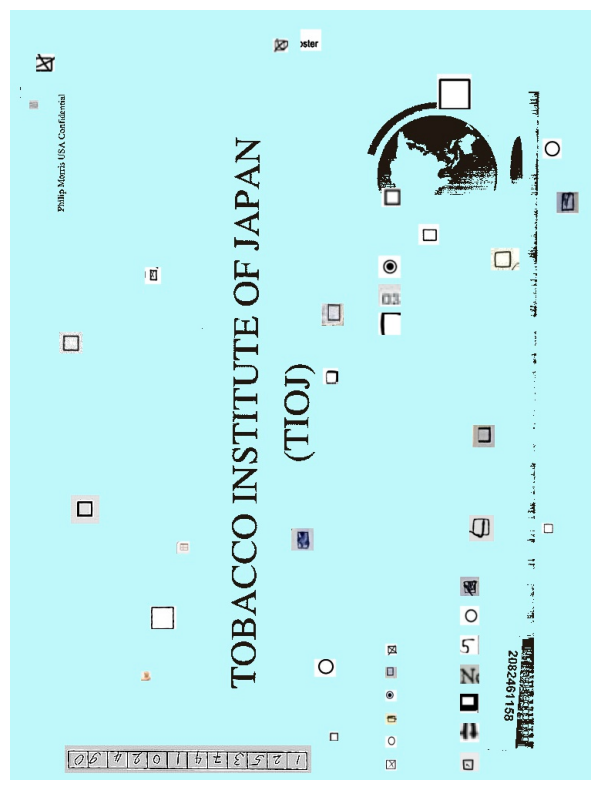

In [42]:
test_document = cv2.imread("datasets/rvl/train/images/10001_presentation.jpg")
visualize(test_document)

Check number of instances of each class

In [41]:
num_checked_boxes = 0
num_unchecked_boxes = 0
num_block_boxes = 0

_, _, label_files = next(os.walk("datasets/rvl/train/labels/"))
complete_label_files = [os.path.join("datasets/rvl/train/labels/", x) for x in label_files if x != '.DS_Store']

for label in complete_label_files:
    with open(label, 'r') as f:
        for line in f:
            if line.split(" ")[0] == "0":
                num_unchecked_boxes += 1
            elif line.split(" ")[0] == "1":
                num_checked_boxes += 1
            elif line.split(" ")[0] == "2":
                num_block_boxes += 1

print(f"Number of unchecked: {num_unchecked_boxes}, number of checked: {num_checked_boxes}, number of blocks: {num_block_boxes}")

Number of unchecked: 205426, number of checked: 205765, number of blocks: 27825


Although the existing documents generated from the copy paste technique provide a relatively good start for training the model, for a well-performing model on real life data, we still need to prepare a set of actual scanned documents containing checkboxes to add to the training data. However, with the lack of public datasets to support this task, we will generate a set of pseudolabels on unlabeled form images and probably hire human annotators to correct the labels

After training our checkbox detector on copy-paste generated data for 200 epochs, we obtain a initial checkpoint, which will be helpful for labelling new, actual data. In addition, to improve the accuracy of the detections, we also use a simple classification model to identify between the 3 classes

In [43]:
DETECTION_MODEL = YOLO("runs/detect/train_all_classes/best.pt") # 0: unchecked, 1: checked, 2: block
CLASSIFICATION_MODEL = YOLO("runs/classify/train/weights/best.pt") # 0: block, 1: checked, 2: unchecked

The main sources of real-life document data containing checkboxes are obtained from public datasets including RVL-CDIP (form and questionnaire categories) and XFUNSD dataset

- xfund: chinese and german
- rvl form and categories: with checkbox and with block

In [5]:
import os, cv2
_, _, rvl_with_checkbox = next(os.walk("datasets/rvl-form/with_checkbox/"))
complete_rvl_with_checkbox = [os.path.join("datasets/rvl-form/with_checkbox/", x) for x in rvl_with_checkbox if x != '.DS_Store']
_, _, xfund_zh_with_checkbox = next(os.walk("datasets/xfund/zh.train/")) # Chinese 
complete_xfund_with_checkbox = [os.path.join("datasets/xfund/zh.train/", x) for x in xfund_zh_with_checkbox if x != '.DS_Store']
_, _, xfund_de_with_checkbox = next(os.walk("datasets/xfund/de.train/")) # German
complete_xfund_with_checkbox.extend([os.path.join("datasets/xfund/de.train/", x) for x in xfund_de_with_checkbox if x != '.DS_Store'])
_, _, rvl_with_block = next(os.walk("datasets/rvl-form/"))
complete_rvl_with_block = [os.path.join("datasets/rvl-form/", x) for x in rvl_with_block if x.find('mst') > 0 and x != '.DS_Store']

Create a folder to store additional training data

In [ ]:
create_folder("datasets/add_train/images")
create_folder("datasets/add_train/labels")

In [6]:
count = -1
for formType in [complete_rvl_with_block, complete_xfund_with_checkbox, complete_rvl_with_checkbox]:
    for _ in formType: # Parse through each file in each folder 
        image = cv2.imread(_)
        if image is None:
            continue
        count += 1
        if count >= 2000: # Prepare a set of 2000 pseudo-labeled images 
            break
        image_w, image_h = image.shape[1], image.shape[0]
        image_filename = str(count) + '_real.jpg'
        txt_filename = str(count) + '_real.txt'
        # Use the checkbox detector to predict on unseen image
        results = DETECTION_MODEL.predict(source=image, conf=0.2)
        boxes = results[0].boxes 
        # Skip if the detector does not find any checkboxes
        if len(boxes) == 0:
            continue
        # If there are checkboxes on the image, save the new image
        cv2.imwrite(f"datasets/add_train/images/{image_filename}", image)

        for box in boxes:
            cls = int(box.cls) # 0: unchecked, 1: checked, 2: unchecked
            start_box = (int(box.xyxy[0][0]), int(box.xyxy[0][1]))
            end_box = (int(box.xyxy[0][2]), int(box.xyxy[0][3]))
            box = image[start_box[1]:end_box[1], start_box[0]: end_box[0], :]
            w, h = box.shape[1], box.shape[0]

            # Determine the class of the box using classification model
            cls_results = CLASSIFICATION_MODEL.predict(source=box, conf=0.5)
            probs = cls_results[0].probs  # cls prob, (num_class, )
            classification_class = 2 - int(probs.top1)
            classification_class_conf = round(probs.top1conf.item(), 2)

            if classification_class_conf > 0.9: cls = classification_class # Update the class to be the class predicted by the classification model
            n_w, n_h = round(float(w)/image_w, 6), round(float(h)/image_h, 6)
            x = (start_box[0] + float(w)/2)/image_w
            y = (start_box[1] + float(h)/2)/image_h
            x, y = round(x, 6), round(y, 6)
            
            # Save the annotations in labels folder
            with open(os.path.join("datasets/add_train/labels/", txt_filename), 'a') as txt_file:
                txt_file.write(str(cls) + " " + str(x) + " " + str(y) + " " + str(n_w) + " " + str(n_h) + "\n")

Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 20 extraneous bytes before marker 0xc4
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code

0: 640x512 36 uncheckeds, 3 checkeds, 185.2ms
Speed: 2.7ms preprocess, 185.2ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 512)

0: 32x32 unchecked 1.00, checked 0.00, block 0.00, 4.3ms
Speed: 2.2ms preprocess, 4.3ms inference, 0.0ms postprocess per image at shape (1, 3, 32, 32)

0: 32x32 unchecked 1.00, checked 0.00, block 0.00, 2.1ms
Speed: 0.5ms preprocess, 2.1ms inference, 0.0ms postprocess per image at shape (1, 3, 32, 32)

0: 32x32 unchecked 1.00, checked 0.00, block 0.00, 2.2ms
Speed: 0.8ms preprocess, 2.2ms inference, 0.0ms postprocess per image at shape (1, 3, 32, 32)

0: 32x32 unchecked 1.00, checked 0.00, block 0.00, 2.0ms
Speed: 0.5ms preprocess, 2.0ms inference, 0.0ms postprocess per image at shape (1, 3, 32, 32)

0: 32x32 unchecked 1.00, checked 0.00, block 0.00, 2.9ms
Speed: 0.7ms preprocess

### **Data Generator: Validation**

We prepare a small validation dataset containing 150 real-life document images to prepare the training process